# Dataset

In [2]:
import pandas as pd
import numpy as np

import os
from datetime import datetime, timedelta
import re

from climso.utils import toSunpyMap

from astropy.coordinates import SkyCoord
import astropy.units as u
from sunpy.coordinates import HeliographicStonyhurst

import matplotlib.pyplot as plt


In [3]:
def convert_to_lon_lat(location):
    # Latitude
    lat_sign = 1 if location[0] == 'N' else -1
    latitude = lat_sign * int(location[1:3])
    
    # Longitude
    lon_sign = -1 if location[3] == 'E' else 1
    longitude = lon_sign * int(location[4:])
    
    return longitude, latitude


# Extract datetime from filename using regex
def extract_datetime_from_filename(filename):
    match = re.search(r'_(\d{8}_\d{6}\d{2})_', filename)
    if match:
        datetime_str = match.group(1)
        try:
            return datetime.strptime(datetime_str, '%Y%m%d_%H%M%S%f')
        except ValueError as e:
            print(f"Error parsing datetime string: {datetime_str}, error: {e}")
    return None


# Find the closest file to a given time
def find_closest_file(target_time, files):
    closest_file_dt = None
    min_diff = timedelta.max
    for file, file_time in files:
        diff = abs(file_time - target_time)
        if diff < min_diff:
            min_diff = diff
            closest_file_dt = (file, file_time)
            
    if min_diff>timedelta(minutes=5): 
        return None
    
    return closest_file_dt

In [4]:
def getTimeSeriesForEvent(event):
        
    # Event start date and time
    event_datetime = datetime.strptime(event['start'], '%Y/%m/%d %H:%M')

    directory = 'Y:/data/CLIMSO/'+str(event_datetime.year)+'/data_calibrated/'+event_datetime.strftime('%Y-%m-%d')+'/'

    if not os.path.exists(directory):
        return None

    ## L1
    
    # List all files in the directory for l1
    l1_files = [file for file in os.listdir(directory) if file.startswith('imoa_06563_l1_')]
    # Create a list of (filename, datetime) tuples
    l1_file_datetimes = [(file, extract_datetime_from_filename(file)) for file in l1_files]
    # Filter out any files that did not match the pattern or had parsing issues
    l1_file_datetimes = [fd for fd in l1_file_datetimes if fd[1] is not None]
    # Sort files by datetime
    l1_file_datetimes.sort(key=lambda x: x[1])
    
    ## L2
    
    # List all files in the directory for l1
    l2_files = [file for file in os.listdir(directory) if file.startswith('imoa_03933_l2_')]
    # Create a list of (filename, datetime) tuples
    l2_file_datetimes = [(file, extract_datetime_from_filename(file)) for file in l2_files]
    # Filter out any files that did not match the pattern or had parsing issues
    l2_file_datetimes = [fd for fd in l2_file_datetimes if fd[1] is not None]
    # Sort files by datetime
    l2_file_datetimes.sort(key=lambda x: x[1])
    

    # Find the files closest to each interval before the event datetime
    l1_closest_files = []
    l2_closest_files = []
    current_time = event_datetime

    for i in range(6):
        current_time -= timedelta(minutes=10)
        l1_closest_file_dt = find_closest_file(current_time, l1_file_datetimes)
        l2_closest_file_dt = find_closest_file(current_time, l2_file_datetimes)
        if l1_closest_file_dt and l2_closest_file_dt:
            l1_closest_files.append(directory+l1_closest_file_dt[0])
            l2_closest_files.append(directory+l2_closest_file_dt[0])
            l1_file_datetimes.remove(l1_closest_file_dt)
            l2_file_datetimes.remove(l2_closest_file_dt)
        elif l1_closest_file_dt is None or l2_closest_file_dt is None:
            return None


    # Output the closest filenames
    return (l1_closest_files, l2_closest_files)

In [5]:
def createSample(event, flip=False):
    
    files = getTimeSeriesForEvent(event)
    if files is None : return
    print('found files |', event['start'], '|', event['AR location'])
    
    lon, lat = convert_to_lon_lat(event['AR location'])
    if np.sqrt(lat**2 + lon**2)>60:
        print('Too close to limb')
        return
    
    label = event['X-ray class'][0]
    
    directory = 'dataset/' + label + '/' + str(event['Event number'])
    os.makedirs(directory, exist_ok=True)
    
    for i in range(6):
        l1_map = toSunpyMap(files[0][i], center_disk=True)
        coord = SkyCoord(lon*u.deg, lat*u.deg,frame=HeliographicStonyhurst, observer='earth', obstime=l1_map.date)
        x, y = [int(pixel_coord.value) for pixel_coord in l1_map.world_to_pixel(coord)]
        y=2048-y

        if flip : 
            data=np.flip(l1_map.data, axis=0) 
        else : 
            data=l1_map.data

        l1_image = data[y-125:y+125, x-125:x+125]
        
        plt.imsave(f'{directory}/img{str(i)}.png', l1_image.astype(np.uint16), cmap='gray', vmin=0, vmax=65535, format='png')

### main

In [6]:
df = pd.read_csv('FlareCatalogue.csv')

### Loop

In [156]:
for index, event in df.iterrows():
    if index>=0: #5782
        flip=index<5782
        print(index, '|', event['Event number'])
        event['start']
        createSample(event, flip=flip)


7236 | 202810
found files | 2022/04/25 12:05 | N17W37
7237 | 202800
7238 | 202790
7239 | 202780
7240 | 202770
7241 | 202760
7242 | 202750
7243 | 202740
7244 | 202730
7245 | 202720
7246 | 202710
7247 | 202700
7248 | 202690
7249 | 202680
7250 | 202670
7251 | 202660
7252 | 202650
7253 | 202640
7254 | 202630
7255 | 202620
7256 | 202610
7257 | 202600
7258 | 202590
7259 | 202580
7260 | 202570
7261 | 202560
7262 | 202550
7263 | 202540
7264 | 202530
7265 | 202520
7266 | 202510
7267 | 202500
7268 | 202490
7269 | 202480
7270 | 202470
7271 | 202460
7272 | 202450
7273 | 202440
7274 | 202430
7275 | 202420
7276 | 202410
7277 | 202400
7278 | 202390
7279 | 202380
7280 | 202370
7281 | 202360
7282 | 202350
7283 | 202340
7284 | 202330
7285 | 202320
7286 | 202310
7287 | 202300
7288 | 202290
7289 | 202280
7290 | 202270
7291 | 202260
7292 | 202250
7293 | 202240
7294 | 202230
7295 | 202220
7296 | 202210
7297 | 202200
7298 | 202190
7299 | 202180
7300 | 202170
found files | 2022/04/18 14:10 | N21E57
Too close 

ValueError: max() iterable argument is empty

### tests

In [7]:
for index, event in df.iterrows():
    if index>=11330:
        files = getTimeSeriesForEvent(event)
        lon, lat = convert_to_lon_lat(event['AR location'])
        if files:break

filename = files[0][0]
index

11330

In [8]:
event

Event number              161870
start           2017/10/08 16:17
peak            2017/10/08 16:21
end             2017/10/08 16:23
AR location               N11W88
X-ray class                 B1.8
FG                             0
SP                           1.0
XRT                            0
EIS                            1
DARTS                        NaN
RHESSI                      6-12
Suzaku/WAM                   NaN
NoRH                         NaN
Name: 11330, dtype: object

In [9]:
from astropy.io import fits

with fits.open(filename) as hdul:
    data = hdul[0].data

In [10]:
data.dtype

dtype('>i2')

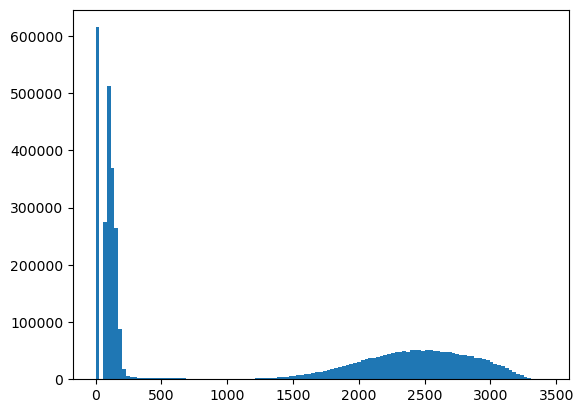

In [11]:
plt.hist(data.flatten(), bins='auto');

In [159]:
from climso.utils import toSunpyMap
map=toSunpyMap(filename, center_disk=True)

KeyError: "Keyword 'RSUN_OBS' not found."

In [146]:
coord = SkyCoord(lon*u.deg, lat*u.deg,frame=HeliographicStonyhurst, observer='earth', obstime=map.date)

x, y = [int(pixel_coord.value) for pixel_coord in map.world_to_pixel(coord)]
y=2048-y
x, y

(1585, 808)

In [147]:
from astropy.io import fits
from climso.utils import centerDisk
with fits.open(filename) as hdul:
    hdu=centerDisk(hdu=hdul[0])
    data=hdu.data

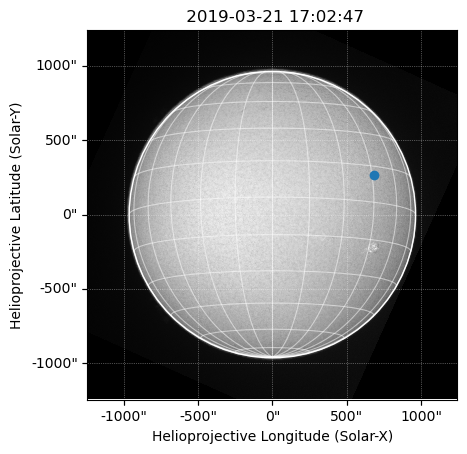

In [149]:
fig = plt.figure()
ax = fig.add_subplot(projection=map)
map.plot(axes=ax)
map.draw_limb(axes=ax)
map.draw_grid(axes=ax)

ax.plot_coord(coord.transform_to(map.coordinate_frame), 'o')

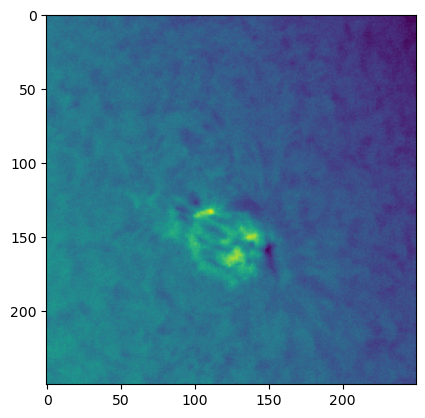

In [150]:
plt.imshow(map.data[y-125:y+125, x-125:x+125])